# GooglePlayDataset

## 1. Preprocessing Two DataSet

### Play Store Apps preprocess
* Becuse the data contain many of un-analysis data format, so we need to transform it
* The feature we will use are the Category, Size, Installs, Price, ContentRating, Last Updated Date

In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from datetime import datetime, date

## load googleplaystore and googleplaystore_user_reviews dataset from csv
playDataset = pd.read_csv('./google-play-store-apps/googleplaystore.txt', names=['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
                                                                                 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
                                                                                 'Android Ver'], skiprows=1)

playDataset.drop(playDataset.index[10472], inplace=True) # abandon corrupt data 'Life Made WI-Fi Touchscreen Photo Frame'

## check with the data reading
#print(appDataset.shape)

## Preprocess playDataset
#print(playDataset.shape)
#playDataset['Rating'].isna().sum()
playDataset.dropna(axis='index', inplace=True) ##Drop all nan value, because the nan in our predicted feature is unusable
# convert all nan to -1
#playDataset.fillna(-1, inplace=True)


# convert the 'Category' datastructure to number
categoryDic = {'ART_AND_DESIGN': 0,
               'AUTO_AND_VEHICLES': 1,
               'BUSINESS' : 2,
               'COMICS' : 3,
               'COMMUNICATION' : 4,
               'DATING' : 5,
               'EDUCATION' : 6,
               'ENTERTAINMENT' : 7, 
               'EVENTS' : 8,
               'FINANCE' : 9,
               'FOOD_AND_DRINK' : 10,
               'HEALTH_AND_FITNESS' : 11,
               'HOUSE_AND_HOME' : 12,
               'LIBRARIES_AND_DEMO' : 13,
               'LIFESTYLE' : 14,
               'GAME' : 15,
               'FAMILY' : 16,
               'MEDICAL' : 17,
               'SOCIAL' : 18,
               'SHOPPING' : 19,
               'PHOTOGRAPHY' : 20,
               'SPORTS' : 21,
               'TRAVEL_AND_LOCAL' : 22,
               'TOOLS' : 23,
               'PERSONALIZATION' : 24,
               'PRODUCTIVITY' : 25,
               'PARENTING': 26,
               'WEATHER' : 27,
               'VIDEO_PLAYERS' : 28,
               'NEWS_AND_MAGAZINES' : 29,
               'MAPS_AND_NAVIGATION' : 30,
               'BEAUTY': 31,
               'BOOKS_AND_REFERENCE' : 32}
def categoryAttributeConvert(string):
    """
    input  a string 
    output is the string  if string not in dictionary dic
    d[string] if string in dictionary dic
    """
    if string in categoryDic:
        return categoryDic[string]
    print(string)
    return string
playDataset.Category = playDataset.Category.apply(categoryAttributeConvert)

# convert the 'Size' datastructure to number
def sizeAttributeConvert(string):
    """
    input is a string (19M or Varies with device')
    output is a numerical number (1900000 or -1)
    """
    if string[-1:] == 'M' :
        numerical = float(string[:-1]) * 1000000
    elif string[-1:] == 'k' :
        numerical = float(string[:-1]) * 1000
    else :
        numerical = float(-1.0)
    return numerical
playDataset.Size = playDataset.Size.apply(sizeAttributeConvert)

# convert the 'Installs' datastructure to number
def installsAttributeConvert(string):
    """
    input is a string (100,000+)
    output is a numerical number (1000000.0)
    """
    if string[-1:] == '+' :
        numerical = float(string[:-1].replace(",",""))
    else :
        numerical = float(-1.0)
    return numerical
playDataset.Installs = playDataset.Installs.apply(installsAttributeConvert)

# convert the 'Price' datastructure to number
def priceAttributeConvert(string):
    """
    input is a string (0, $3.99)
    output is a numerical number (0, 3.99)
    """
    try:
        if string[0] == '$' :
            numerical = float(string[1:])
        else :
            numerical = float(string)
    except:
        numerical = float(-1)
    return numerical
playDataset.Price = playDataset.Price.apply(priceAttributeConvert)

# convert the 'ContentRating' datastructure to number
contentRatingDic = {'Everyone': 0,
                    'Everyone 10+': 1,
                    'Teen' : 2,
                    'Mature 17+' : 3,
                    'Adults only 18+' : 4,
                    'Unrated' : 5}
def contentRatingAttributeConvert(string):
    """
    input  a string 
    output is the string  if string not in dictionary dic
    d[string] if string in dictionary dic
    """
    if string in contentRatingDic:
        return contentRatingDic[string]
    print(string)
    return string
playDataset['Content Rating'] = playDataset['Content Rating'].apply(contentRatingAttributeConvert)

# convert the 'Last Updated' datastructure to number
timeFormat = pd.to_datetime(playDataset['Last Updated'])
timeFormat.head()
def dateAttributeConvert(string):
    deltaDay = date.today()-datetime.date(string)
    try:
        numericalDay = int(str(deltaDay).split(' ')[0])
    except ValueError:
        print("ERROR")
    return numericalDay
playDataset['Last Updated Days'] = timeFormat.apply(dateAttributeConvert)

#playDataset.head()
print(playDataset.count())


App                  9360
Category             9360
Rating               9360
Reviews              9360
Size                 9360
Installs             9360
Type                 9360
Price                9360
Content Rating       9360
Genres               9360
Last Updated         9360
Current Ver          9360
Android Ver          9360
Last Updated Days    9360
dtype: int64


### User Review Dataset Preprocessing
* The feature we will use are the userReviewScore we calculate from Sentiment_Polarity and Sentiment_Subjectivity

In [255]:
## preprocess userReviewDataset
userReviewDataset = pd.read_csv('./google-play-store-apps/googleplaystore_user_reviews.txt', names=['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity',
                                                                                                    'Sentiment_Subjectivity'], skiprows=1)

# convert all nan to 0
userReviewDataset.fillna(0, inplace=True)

# calculate the Sentiment_Polarity with weight(Sentiment_Subjectivity) 
# calculate the sentiment score of every app
userReviewDataset['Sentiment_Weight'] = userReviewDataset.apply(lambda x: float(x['Sentiment_Polarity']) * float(x['Sentiment_Subjectivity']), axis=1)
# get sum of Subjectivity bias and calculate the userReviewScore with bias
userReviewGroupByApp = userReviewDataset.groupby('App')
userReviewScoreSeries = userReviewGroupByApp.sum().apply(lambda x: float(x['Sentiment_Weight'])/float(x['Sentiment_Subjectivity'])
                                                                        if float(x['Sentiment_Subjectivity'])>0 else 0, axis=1)
# generae pd Dataframe from the score series
userReviewScoreSeries = pd.DataFrame({'App':userReviewScoreSeries.index, 'User Review':userReviewScoreSeries.values})

## combine userReviewSet into playDataset, and use appDataset to do the following training
appDataset = pd.merge(playDataset, userReviewScoreSeries, on=['App'], how='left')
appDataset.drop(columns=['App', 'Type', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'], inplace=True)
appDataset.fillna(-1, inplace=True)
appDataset.head()


,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Last Updated Days,User Review
0,0,4.1,159,19000000.0,10000.0,0.0,0,285,-1.00000
1,0,3.9,967,14000000.0,500000.0,0.0,0,277,0.14445
2,0,4.7,87510,8700000.0,5000000.0,0.0,0,79,-1.00000
3,0,4.5,215644,25000000.0,50000000.0,0.0,2,133,-1.00000
4,0,4.3,967,2800000.0,100000.0,0.0,0,121,-1.00000


## 2. Visualization
* To evaluate what we can do with out dataset

<Figure size 432x288 with 0 Axes>

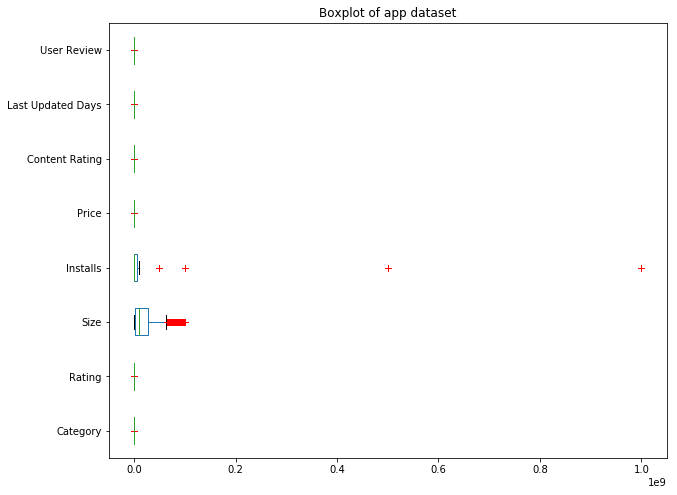

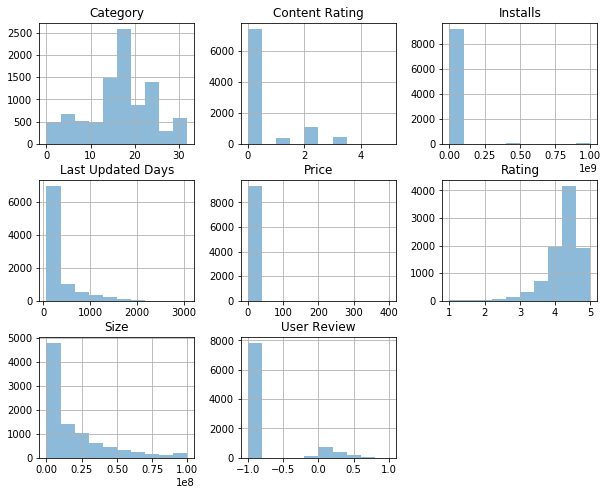

In [256]:
plt.figure();
## plot the Box
appDataset.plot.box(sym='r+', title='Boxplot of app dataset', figsize=(10, 8), vert=False)
## plot the histogram
appDataset.hist(alpha=0.5, figsize=(10, 8)) #, title='Histogram of app dataset'
plt.draw_all()


[  9.39610838e-01   5.97387149e-02   6.50446718e-04   1.71472987e-11
   2.82162936e-14   5.91283655e-15   8.44869179e-17   2.95725351e-17
   2.11597582e-17]
[  8.33368482e+15   5.29840229e+14   5.76900321e+12   1.52084435e+05
   2.50258605e+02   5.24426860e+01   7.49339318e-01   2.62287510e-01
   1.87672118e-01]
[  9.39610838e-01   5.97387149e-02   6.50446718e-04   1.71472987e-11
   2.82162936e-14   5.91283655e-15   8.44869179e-17   2.95725351e-17]
[  8.33368482e+15   5.29840229e+14   5.76900321e+12   1.52084435e+05
   2.50258605e+02   5.24426860e+01   7.49339318e-01   2.62287510e-01]
mle


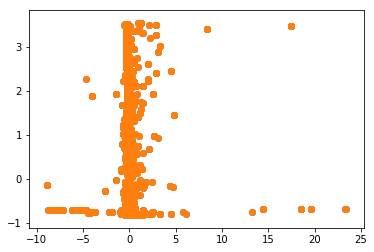

In [240]:
# PCA Analysis (IGNORE IT, JUST FOR TESTING ONLY)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=9)
pca.fit(appDataset)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

pca2 = PCA(n_components='mle', svd_solver='full', whiten=True)
pca2.fit(appDataset)
print(pca2.explained_variance_ratio_)
print(pca2.explained_variance_)
print(pca2.n_components)

appVisual = pca2.transform(appDataset)
plt.scatter(appVisual[:, 2], appVisual[:, 1])
plt.scatter(appVisual[:, 2], appVisual[:, 1])
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(appVisual[:, 0], appVisual[:, 1], appVisual[:, 2])
# ax.scatter(appVisual[:, 0], appVisual[:, 1], appVisual[:, :1])

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# plt.show()

#### 3. Decision Tree model wit K-fold Validation

accuracy : 0.754915
rating 0 precision : nan
rating 0 recall : nan
rating 1 precision : 0.200000
rating 1 recall : 0.053571
rating 2 precision : 0.244444
rating 2 recall : 0.095238
rating 3 precision : 0.417959
rating 3 recall : 0.299415
rating 4 precision : 0.821236
rating 4 recall : 0.900127
rating 5 precision : 0.569231
rating 5 recall : 0.540146


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in long_scalars


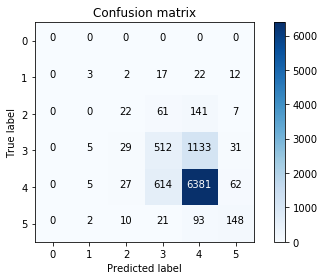

In [262]:
import numpy as np
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import random
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import itertools

#transform the google play data to array type
appDatasetArray = np.asarray(appDataset)
#split data into features data and target data. In this case, we predict the rating as targrt
data = np.array([appDataset['Category'],appDataset['Price'], appDataset['Installs'],appDataset['Content Rating'], appDataset['Size'],appDataset['Reviews'], appDataset['User Review'], appDataset['Last Updated Days']]) #
#np.delete(appDatasetArray,1,axis=1)
#target = appDatasetArray[:,1]
target= np.array(appDataset['Rating']).astype('int') #
#target.astype('int')
data = data.transpose()
#print(data.shape[0])
#print(appDataset['Rating'].unique())

treeNum = 15
## Do the attribute bagging or not
attrBagging = 0
K_fold_n_splits = data.shape[1]
##K-fold forest
kf = KFold(n_splits=K_fold_n_splits,shuffle=True)
rating = [0, 1, 2, 3, 4, 5]
confusionMatrix = 0

KfoldTotalAccuracy = 0.
for train_index, test_index in kf.split(data):
    #split the data set into training set and validation set
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = target[train_index], target[test_index]
    
    tree_attr_index = [] #used for record the delete attribute index in attribute bagging mode
    CLF = []
    predictedOutcome = []
    votedOutcome = []
    
    for i in range(treeNum):
        random.shuffle(train_index) #shuffle the index for building the random forest
        treeIndex = train_index[0:int(train_index.shape[0]*0.7)]
        randomTree_x = data[treeIndex]
        randomTree_y = target[treeIndex]
        
        if(attrBagging ==1):
            # create the suffle index for each attribute
            index_shuf = np.arange(randomTree_x.shape[1])
            random.shuffle(index_shuf)
            
            # delete the specific columns for training data(attribute bagging)
            temp = np.delete(randomTree_x,index_shuf[0:int(index_shuf.shape[0]*0.5)],axis=1)
            #record the index of attribute for each tree
            tree_attr_index.append(index_shuf[0:int(index_shuf.shape[0]*0.5)])
           
            
            # train the data
            clf = tree.DecisionTreeClassifier()
            #print(randomTree_y)
            CLF.append(clf.fit(temp, randomTree_y))
        else:
            clf = tree.DecisionTreeClassifier()
            CLF.append(clf.fit(randomTree_x, randomTree_y))
    ##predict
    totolScore = 0.
    for i in range(treeNum):
        if(attrBagging ==1):
            # need to predict the data in same atrribute for specific tree
            validate_x = np.delete(X_test,tree_attr_index[i],axis=1)
            predictedOutcome.append(CLF[i].predict(validate_x))
        else:
            predictedOutcome.append(CLF[i].predict(X_test))
            
    for i in range(len(y_test)):
        vote = [0] * len(rating)
        mostVotingCount = 0
        mostVotingIndex = 0
        for j in range(treeNum):
            for k in range(len(rating)):
                if(predictedOutcome[j][i] == rating[k]):
                    vote[k] += 1
        #print(vote)

        for j in range(len(rating)):
            if(vote[j] > mostVotingCount):
                mostVotingCount = vote[j]
                mostVotingIndex = j

        votedOutcome.append(rating[mostVotingIndex])
        #print(votedOutcome)

    actualOutcome = y_test
    #print(len(actualOutcome))
    #print(len(votedOutcome))
    confusionMatrix += confusion_matrix(actualOutcome, votedOutcome, labels = rating)

accuracy = 0
for i in range(len(rating)):
    accuracy += confusionMatrix[i][i]
accuracy = accuracy / data.shape[0]
print('accuracy : {:f}'.format(accuracy))
    
for i in range(len(rating)):
    precision = 0
    recall = 0
    for j in range(len(rating)):
        if(j == i):
            precision += confusionMatrix[j][j]
            recall += confusionMatrix[j][j]
        else:
            precision += confusionMatrix[j][i]
            recall += confusionMatrix[i][j]
    precision = confusionMatrix[i][i] / precision
    recall = confusionMatrix[i][i] / recall
    print('rating {:d} precision : {:f}'.format(rating[i], precision))
    print('rating {:d} recall : {:f}'.format(rating[i], recall))


plt.imshow(confusionMatrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(rating))
plt.xticks(tick_marks, rating)
plt.yticks(tick_marks, rating)

fmt = 'd'
thresh = confusionMatrix.max() / 2.
for i, j in itertools.product(range(confusionMatrix.shape[0]), range(confusionMatrix.shape[1])):
    plt.text(j, i, format(confusionMatrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if confusionMatrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
    

## 4. Decision Tree model wit Resubstitution Validation

accuracy : 1.000000
rating 0 precision : nan
rating 0 recall : nan
rating 1 precision : 1.000000
rating 1 recall : 1.000000
rating 2 precision : 1.000000
rating 2 recall : 1.000000
rating 3 precision : 1.000000
rating 3 recall : 1.000000
rating 4 precision : 1.000000
rating 4 recall : 1.000000
rating 5 precision : 1.000000
rating 5 recall : 1.000000


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in long_scalars


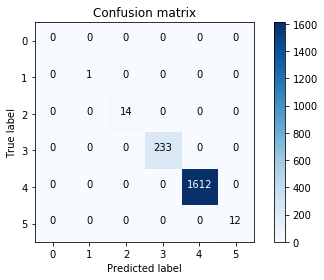

In [263]:
#define the portion of dataset here
xTrain, xTest, yTrain, yTest = train_test_split(data, target, test_size = 0.75)
totolScore = 0.
tree_attr_index =[]
CLF_ = []
confusionMatrix = 0
predictedOutcome = []
votedOutcome = []

#Do the attribute baggong or not
attrBagging = 0
for i in range(treeNum):
    # create the suffle index for each data
    index_shuf = np.arange(xTrain.shape[0])
    random.shuffle(index_shuf)
    
    #define the portion of training dataset for single tree here
    treeIndex = index_shuf[0:int(xTrain.shape[0]*0.8)]
    randomTree_x = data[treeIndex]
    randomTree_y = target[treeIndex]
    
    if(attrBagging ==1):
        # create the suffle index for each attribute (same as K-fold)
        index_shuf = np.arange(randomTree_x.shape[1]*1)
        random.shuffle(index_shuf)
        temp = np.delete(randomTree_x,index_shuf[0:int(index_shuf.shape[0]*0.5)],axis=1)
        tree_attr_index.append(index_shuf[0:int(index_shuf.shape[0]*0.5)])
        clf = tree.DecisionTreeClassifier()
        CLF_.append(clf.fit(temp, randomTree_y))
    else:
        clf = tree.DecisionTreeClassifier()
        CLF_.append(clf.fit(randomTree_x, randomTree_y))

for i in range(treeNum):
    if(attrBagging ==1):
        validate_x = np.delete(randomTree_x,tree_attr_index[i],axis=1)
        predictedOutcome.append(CLF_[i].predict(validate_x))
    else:
        predictedOutcome.append(CLF_[i].predict(randomTree_x))
    
for i in range(len(randomTree_y)):
    vote = [0] * len(rating)
    mostVotingCount = 0
    mostVotingIndex = 0
    for j in range(treeNum):
        for k in range(len(rating)):
            if(predictedOutcome[j][i] == rating[k]):
                vote[k] += 1
    #print(vote)
                
    for j in range(len(rating)):
        if(vote[j] > mostVotingCount):
            mostVotingCount = vote[j]
            mostVotingIndex = j
    
    votedOutcome.append(rating[mostVotingIndex])
    
#print(votedOutcome)
    
actualOutcome = randomTree_y
confusionMatrix = confusion_matrix(actualOutcome, votedOutcome, labels = rating)

#print(confusionMatrix)

accuracy = 0
for i in range(len(rating)):
    accuracy += confusionMatrix[i][i]
accuracy = accuracy / len(randomTree_y)
print('accuracy : {:f}'.format(accuracy))

for i in range(len(rating)):
    precision = 0
    recall = 0
    for j in range(len(rating)):
        if(j == i):
            precision += confusionMatrix[j][j]
            recall += confusionMatrix[j][j]
        else:
            precision += confusionMatrix[j][i]
            recall += confusionMatrix[i][j]
    precision = confusionMatrix[i][i] / precision
    recall = confusionMatrix[i][i] / recall
    print('rating {:d} precision : {:f}'.format(rating[i], precision))
    print('rating {:d} recall : {:f}'.format(rating[i], recall))


plt.imshow(confusionMatrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(rating))
plt.xticks(tick_marks, rating)
plt.yticks(tick_marks, rating)

fmt = 'd'
thresh = confusionMatrix.max() / 2.
for i, j in itertools.product(range(confusionMatrix.shape[0]), range(confusionMatrix.shape[1])):
    plt.text(j, i, format(confusionMatrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if confusionMatrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()